In [1]:
from CoolProp.CoolProp import PropsSI
import random 
# use the letters:
# ... T for (T)emperature 
# ... P for (P)ressure
# ... D for (D)ensity (use the density to calculate the specific volume)
# ... Q for vapor quality x

<img src="basic-CAES-model.png">

In [190]:
#Boundary conditions and constants

#Ambiant air
p1 = 1.013e5   # Pa
T1 = 273.15+20 # K
Ra = 287.06    # J/kgK
cp = 1059.7    # J/kgK

#Miscellaneous
gamma = cp/(cp-Ra) #[-]
Pwind = 300e6      # W
t_rampup = 15*60   # s
T3 = 893.15        # K
T4 = 323.15        # K
T5 = 873.15        # K
mdot_max = 500     # kg/s

#Cavern
V = 500000    # m^3         
p4max = 150e5 # Pa       
p4min = 100e5 # Pa

#TES 
eff_TES = 0.977

#Compressor
eff_c   = 0.875 #[-]
n_c = eff_c*gamma/(eff_c*gamma-gamma+1) #[-]
Pc_max = 300e6 # max compressor power

#Turbine
eff_t   = 0.925 #[-]
n_t = eff_t*gamma/(eff_t*gamma-gamma+1) #[-]
Pt_max = 300e6 # max turbine power

#Motor & Generator
eff_m = 0.98 #[-]
eff_g = 0.98 #[-]



#Functions

#Input power, including start up time compressor, without eff_m
def Pin(t):
    if t > t_rampup:
        Pin = Pwind
    else:
        Pin = Pwind*t/t_rampup
    return Pin


#Starting conditions

#Initial pressure in cavern
p4 = p4min

t=15*60 #Test value, should be t=0 for model and change in loop



#Other code

#Isothermal relation for temperature after compression, p4 = p2 = pcavern = f(t)
#According to paper the results should be 1120K for 100 bar and 1255K for 150 bar
#Formula with compressor efficiency models this better, should we change this @Walid
def Tcompr(p4):
    T2=T1*(p4/p1)**((gamma-1)/gamma)
    return T2

# mass flow as a function of time
def mdot(t, p4):
    #Specific work theoretical equation
    #Will change bc p4 = f(t)
    dh = n_c/(n_c-1)/eff_c*Ra*T1*((p4/p1)**((n_c-1)/n_c)-1)

    #Specific heat reduction for temperature restrictions (q23)
    #Will change bc Tcompr = f(p4) and p4 = f(t)
    q = cp*(T3-Tcompr(p4)) # multiply by mdot?
    return Pin(t)/(dh/eff_m+abs(q))


In [191]:
# TES, cavern and turbine


# Heat exchange across TES
def q34dot(t, p4):
    return mdot(t, p4) * cp *(T4 - (T3-20))
    
def q45dot(t):
    return mdot(t, p4) * cp * (T5 - T4)

def p4(t):
    p4 = p4min
    dt = 0.01
    
    for i in np.linspace(0, t, 1/dt):
        p4 += mdot(i, p4) * dt * Ra * T4 / V
    return p4
     
def p6(t):
    p5 = p4(t)
    return p5 / 6

# turbine output power
def P56(t):
    return mdot(t, p4) * eff_t * (n_t / (n_t - 1)) * Ra * T5 * ( (p6(t)/p5) ** ((n_t-1)/n_t) - 1)

# exit temperature
def T6(t):
    p5 = p4(t) # Assuming no pressure loss over TES
    return T5 * (p6(t)/ p5) ** ((n_t-1)/n_t)

In [192]:
import matplotlib.pyplot as plt
import numpy as np

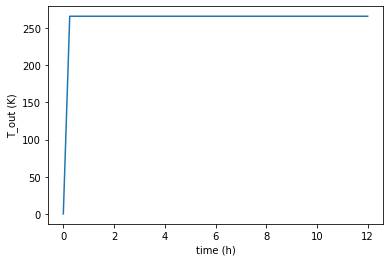

max, min pressure 265.9629 0.0 bar


In [196]:
x = []
y = []
for i in np.linspace(0, 12*60*60, 1000): 
    x.append(i/60/60)
    y.append(mdot(i,p4(i)))
plt.plot(x, y)
plt.xlabel("time (h)")
plt.ylabel("T_out (K)")
plt.show()
print("max, min pressure", round(max(y),5), min(y), "bar")